## 1. Data Loading

In [2]:
# import all packages needed
import pandas as pd
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
import os
import sys
import time
import pickle
from sklearn.dummy import DummyClassifier
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from fuzzywuzzy import fuzz
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/Users/chenlujia/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# load the dataset and find the active users
import pandas as pd
import json
from tqdm import tqdm
line_count = len(open("yelp_dataset/review.json").readlines())
user_ids, business_ids, stars, dates = [], [], [], []
with open("yelp_dataset/review.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
ratings = pd.DataFrame(
    {"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates}
)
user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

100%|██████████| 6685900/6685900 [00:59<00:00, 112618.01it/s]


In [3]:
ratings.head()

,user_id,business_id,rating,date
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,2013-05-07 04:34:36
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,2016-11-09 20:09:03
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,2018-01-09 20:56:38
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,2018-01-30 23:07:38


## 2. Baseline Model by DummyClassifier

In [5]:
# select the active users in the dataset
ratings_active = ratings[ratings.user_id.isin(active_users)]

In [6]:
# hold the last rating of each user as the test set, and the other ratings of each user as training set
ratings_group = ratings_active.groupby('user_id', as_index=False)

In [7]:
ratings_byDate = ratings_group.apply(lambda _ratings_group: _ratings_group.sort_values(by=['date']))

In [8]:
ratings_byDate = ratings_byDate.set_index('user_id')

In [9]:
ratings_test = ratings_byDate.groupby('user_id').tail(1)

In [10]:
ratings_train = ratings_byDate.groupby('user_id').apply(lambda _ratings_byDate: _ratings_byDate.iloc[:-1])

In [11]:
ratings_train.reset_index(level=0, inplace=True)
ratings_test.reset_index(level=0, inplace=True)

In [12]:
ratings_train_x = ratings_train.iloc[:,:2]
ratings_train_y = ratings_train.iloc[:,2]
ratings_test_x = ratings_test.iloc[:,:2]
ratings_test_y = ratings_test.iloc[:,2]

In [71]:
# Baseline test (DummyClassifier)
dummyModel = DummyClassifier(strategy="most_frequent")
dummyModel.fit(ratings_train_x, ratings_train_y)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [73]:
print(dummyModel.score(ratings_test_x, ratings_test_y))

0.5028728200468319


As seen above, we used the DummyClassifier from sklearn package as our baseline model. We treat the problem as a classifier problem as there are 5 possible outcomes for the ratings. When tested on the baseline model, we get the mean accuracy score 0.5, which we treat as our baseline accuracy.

## 3. SVD Model

In [23]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data_train = Dataset.load_from_df(ratings_train[['user_id','business_id','rating']], reader)
new_data_test = Dataset.load_from_df(ratings_test[['user_id','business_id','rating']], reader)

In [44]:
# instantiate the model
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
print(cross_validate(algorithm, new_data_train, measures=['FCP', 'MAE'], cv=5, verbose=True))

Evaluating FCP, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
FCP (testset)     0.5899  0.5911  0.5883  0.5880  0.5913  0.5897  0.0014  
MAE (testset)     0.9464  0.9464  0.9462  0.9458  0.9441  0.9458  0.0009  
Fit time          220.30  209.43  224.96  223.75  216.70  219.03  5.60    
Test time         33.85   56.07   51.44   58.34   33.85   46.71   10.73   
{'test_fcp': array([0.58985751, 0.59107861, 0.58832375, 0.58797544, 0.59127529]), 'test_mae': array([0.94642572, 0.9464262 , 0.9462291 , 0.94575678, 0.94410832]), 'fit_time': (220.30108380317688, 209.42786407470703, 224.9608130455017, 223.7523012161255, 216.69667887687683), 'test_time': (33.84821009635925, 56.06706786155701, 51.436155796051025, 58.34398007392883, 33.84874224662781)}


As shown above, we use SVD model to cross validate on the training set, and the FCP and MAE scores indicate that the model fits pretty well on the training set. 

In [43]:
# Get the trainset and testset
trainset, testset_null = train_test_split(new_data_train, test_size=0.001)
trainset_null, testset = train_test_split(new_data_test, test_size=0.999)

In [38]:
start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

# Make predictions and check the accurancy
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

228.2971429824829


## 3.1 Train on all active users and test on different groups of users

### 3.1.1 Accuracy scores for all active users

In [41]:
accuracy.fcp(predictions)
accuracy.mae(predictions)

FCP:  0.5911
MAE:  0.9484


0.9483691153864773

As shown above, we train the SVD model on the training set and test it on the testset. From the FCP score and the MAE score, we can tell that the model also gives good predictions for the testset.

In [62]:
for index in predictions[:20]:
    print('user_id:',index[0], ' predicted_rating:',index[3], ' actual_rating:',index[2])

user_id: D43OWyfzIQjL8feJpYh2SQ  predicted_rating: 4.228982083535216  actual_rating: 5.0
user_id: K-nJvlZKQOHp1R5CkHh0Eg  predicted_rating: 3.9655607191279367  actual_rating: 3.0
user_id: g5ihTl7F8VmVuKHtpPYCaw  predicted_rating: 3.798063529906925  actual_rating: 2.0
user_id: ntLOxCEnWYT4nbqm8s2OEA  predicted_rating: 3.787484031657568  actual_rating: 4.0
user_id: 2wt-t_0TwwU5XqZY-b5ZUA  predicted_rating: 3.0902782380266127  actual_rating: 4.0
user_id: zerj914l8J7o6tHDtun42A  predicted_rating: 4.752392593452944  actual_rating: 5.0
user_id: -w97ixdca92JmfcSot7FOQ  predicted_rating: 3.79611479162273  actual_rating: 4.0
user_id: -8MACpGwGFRa-oyecgJRRg  predicted_rating: 3.5222860053179867  actual_rating: 1.0
user_id: y2V68RT5BkIFT9LEVfCvJQ  predicted_rating: 3.445527373573  actual_rating: 5.0
user_id: T8qlIljTLURyvSm5ZIlrjw  predicted_rating: 3.263664341974304  actual_rating: 3.0
user_id: uJ7xdV3rgKPM0ufyZn7Lfw  predicted_rating: 3.3128902565930147  actual_rating: 4.0
user_id: ebbf9ysSqQi4

The information above is from the predictions given by the model for the first 20 users' last ratings. Both the real ratings and the predicted ratings are shown. Comparing the predicted ratings and the real ratings, most of them are close to each other for the same user.

### 3.1.2 Accuracy scores for last 10k active users (not prolific)

In [191]:
# Get the rating predictions for last 10k active users
last_10k_users = []
for i in range(len(predictions)):
    if predictions[i][0] in ratings_test.user_id[-10000:].tolist():
        last_10k_users.append(predictions[i])

In [119]:
# get the accuracy scores for the last 10k active users
accuracy.fcp(last_10k_users)
accuracy.mae(last_10k_users)

FCP:  0.5798
MAE:  0.9569


0.9569484993480656

### 3.1.3 Accuracy scores for first 10k active users (prolific)

In [120]:
# get the rating predictions for the first 10k active users
first_10k_users = []
for i in range(len(predictions)):
    if predictions[i][0] in ratings_test.user_id[:10000].tolist():
        first_10k_users.append(predictions[i])

In [121]:
# get the accuracy scores for the first 10k active users
accuracy.fcp(first_10k_users)
accuracy.mae(first_10k_users)

FCP:  0.5961
MAE:  0.9478


0.9477894591245409

### 3.1.4 Accuracy scores for second last 10k active users (not prolific)

In [141]:
# get the rating predictions for the second last 10k active users
second_last_10k_users = []
for i in range(len(predictions)):
    if predictions[i][0] in ratings_test.user_id[-20000:-10000].tolist():
        second_last_10k_users.append(predictions[i])

In [142]:
# get the accuracy scores for the second last 10k active users
accuracy.fcp(second_last_10k_users)
accuracy.mae(second_last_10k_users)

FCP:  0.5986
MAE:  0.9523


0.9523215785091909

Now we draw a line chart to compare the accuracy scores for different user groups, including all active users, the first 10k prolific users and the first 10k non-prolific users. 

As shown in the charts below, there's no big difference in the accuracy scores for different groups of users for the SVD model according to the users' activeness if trained on the dataset of all active users.

Text(0, 0.5, 'MAE score')

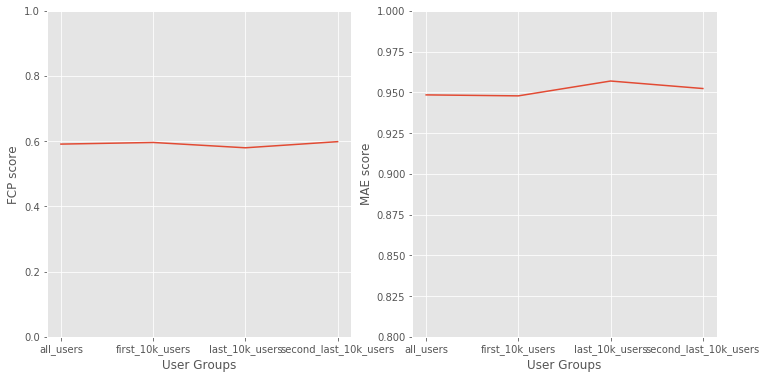

In [143]:
fig, ax=plt.subplots(1,2,figsize=(12,6))
ax[0].plot(['all_users','first_10k_users','last_10k_users','second_last_10k_users'],[0.5911,0.5961,0.5798,0.5986])
ax[0].set_ylim(0,1)
ax[0].set_xlabel('User Groups')
ax[0].set_ylabel('FCP score')
ax[1].plot(['all_users','first_10k_users','last_10k_users','second_last_10k_users'],[0.9484,0.9478,0.9569,0.9523])
ax[1].set_ylim(0.8,1)
ax[1].set_xlabel('User Groups')
ax[1].set_ylabel('MAE score')

## 3.2 Train and Test on less prolific users

### 3.2.1 Accuracy scores for users with 5-10 reviews

In [145]:
ratings_byDate.reset_index(level=0, inplace=True)

In [186]:
user_counts = ratings_byDate["user_id"].value_counts()
active_users = user_counts.loc[user_counts <= 10].index.tolist()
ratings_less_than_10 = ratings_byDate[ratings_byDate.user_id.isin(active_users)]

ratings_train = ratings_less_than_10.groupby('user_id').apply(lambda _ratings_less_than_10: _ratings_less_than_10.iloc[:-1])
ratings_test = ratings_less_than_10.groupby('user_id').tail(1)

# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data_train = Dataset.load_from_df(ratings_train[['user_id','business_id','rating']], reader)
new_data_test = Dataset.load_from_df(ratings_test[['user_id','business_id','rating']], reader)

# instantiate the model
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
#print(cross_validate(algorithm, new_data_train, measures=['FCP', 'MAE'], cv=5, verbose=True))

# Get the trainset and testset
trainset, testset_null = train_test_split(new_data_train, test_size=0.001)
trainset_null, testset = train_test_split(new_data_test, test_size=0.999)

start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

# Make predictions and check the accurancy
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

79.16412472724915


In [160]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.3680
MAE:  1.1263


1.126280843782891

In [187]:
len(predictions)

177398

### 3.2.2 Accuracy scores for users with 5-7 reviews

In [184]:
user_counts = ratings_byDate["user_id"].value_counts()
active_users = user_counts.loc[user_counts <= 7].index.tolist()
ratings_less_than_7 = ratings_byDate[ratings_byDate.user_id.isin(active_users)]

ratings_train = ratings_less_than_7.groupby('user_id').apply(lambda _ratings_less_than_7: _ratings_less_than_7.iloc[:-1])
ratings_test = ratings_less_than_7.groupby('user_id').tail(1)

# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data_train = Dataset.load_from_df(ratings_train[['user_id','business_id','rating']], reader)
new_data_test = Dataset.load_from_df(ratings_test[['user_id','business_id','rating']], reader)

# instantiate the model
algorithm = SVD()

# Get the trainset and testset
trainset, testset_null = train_test_split(new_data_train, test_size=0.001)
trainset_null, testset = train_test_split(new_data_test, test_size=0.999)

start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

# Make predictions and check the accurancy
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

37.11776685714722


In [162]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.3878
MAE:  1.1556


1.1556315553186534

In [185]:
len(predictions)

123057

### 3.2.3 Accuracy scores for users with 5-15 reviews

In [182]:
user_counts = ratings_byDate["user_id"].value_counts()
active_users = user_counts.loc[user_counts <= 15].index.tolist()
ratings_less_than_15 = ratings_byDate[ratings_byDate.user_id.isin(active_users)]

ratings_train = ratings_less_than_15.groupby('user_id').apply(lambda _ratings_less_than_15: _ratings_less_than_15.iloc[:-1])
ratings_test = ratings_less_than_15.groupby('user_id').tail(1)

# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data_train = Dataset.load_from_df(ratings_train[['user_id','business_id','rating']], reader)
new_data_test = Dataset.load_from_df(ratings_test[['user_id','business_id','rating']], reader)

# instantiate the model
algorithm = SVD()

# Get the trainset and testset
trainset, testset_null = train_test_split(new_data_train, test_size=0.001)
trainset_null, testset = train_test_split(new_data_test, test_size=0.999)

start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

# Make predictions and check the accurancy
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

95.23886895179749


In [165]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.3518
MAE:  1.1044


1.1044251988189462

In [183]:
len(predictions)

220392

### 3.2.4 Accuracy scores for users with 15-25 reviews

In [173]:
user_counts = ratings_byDate["user_id"].value_counts()
active_users = user_counts.loc[(user_counts <= 25)&(15 <= user_counts)].index.tolist()
ratings_less_than_20 = ratings_byDate[ratings_byDate.user_id.isin(active_users)]

ratings_train = ratings_less_than_20.groupby('user_id').apply(lambda _ratings_less_than_20: _ratings_less_than_20.iloc[:-1])
ratings_test = ratings_less_than_20.groupby('user_id').tail(1)

# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data_train = Dataset.load_from_df(ratings_train[['user_id','business_id','rating']], reader)
new_data_test = Dataset.load_from_df(ratings_test[['user_id','business_id','rating']], reader)

# instantiate the model
algorithm = SVD()

# Get the trainset and testset
trainset, testset_null = train_test_split(new_data_train, test_size=0.001)
trainset_null, testset = train_test_split(new_data_test, test_size=0.999)

start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

# Make predictions and check the accurancy
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

40.64778184890747


In [176]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.3533
MAE:  1.1042


1.104176718198299

In [181]:
len(predictions)

38328

Now we draw a line chart to compare the accuracy scores for different user groups, including users with 5-7 review, users with 5-10 reviews and users with 5-15 reviews.

As shown in the first two charts below, as the users become more active (more reviews), the accuracy scores decrease, which indicates that traning on the dataset with more active users (more reviews) will give better predictions.

(Note that the accuracy scores here are RMSE and MAE, both indicate better predictions when becoming smaller, indicating smaller total errors.)

In the third chart, we draw the line chart indicating the number of users in each training and testing process. Although for the last training, there are only 38,328 users, which is far smaller than the numbers of users in the other training processes, the accuracy is better than the others as there are more reviews for each user and thus the last rating for each user can be better predicted.

Text(0, 0.5, '#Users')

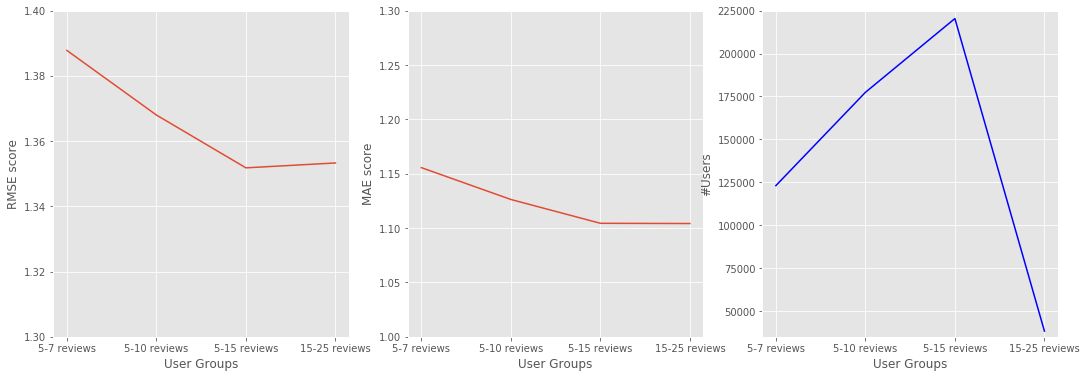

In [190]:
fig, ax=plt.subplots(1,3,figsize=(18,6))
ax[0].plot(['5-7 reviews','5-10 reviews','5-15 reviews','15-25 reviews'],[1.3878,1.3680,1.3518,1.3533])
ax[0].set_ylim(1.3,1.4)
ax[0].set_xlabel('User Groups')
ax[0].set_ylabel('RMSE score')
ax[1].plot(['5-7 reviews','5-10 reviews','5-15 reviews','15-25 reviews'],[1.1556,1.1263,1.1044,1.1042])
ax[1].set_ylim(1.0,1.3)
ax[1].set_xlabel('User Groups')
ax[1].set_ylabel('MAE score')

ax[2].plot(['5-7 reviews','5-10 reviews','5-15 reviews','15-25 reviews'],[123057,177398,220392,38328],c='b')
ax[2].set_ylim(35000,225000)
ax[2].set_xlabel('User Groups')
ax[2].set_ylabel('#Users')

## 3.3 Train and Test on less popular businesses

### 3.3.1 Accuracy scores for businesses with more than 100 reviews

In [4]:
business_counts = ratings["business_id"].value_counts()
popular_business = business_counts.loc[business_counts >= 100].index.tolist()
ratings_popular_business = ratings[ratings.business_id.isin(popular_business)]

ratings_train = ratings_popular_business.groupby('user_id').apply(lambda _ratings_popular_business: _ratings_popular_business.iloc[:-1])
ratings_test = ratings_popular_business.groupby('user_id').tail(1)

# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data_train = Dataset.load_from_df(ratings_train[['user_id','business_id','rating']], reader)
new_data_test = Dataset.load_from_df(ratings_test[['user_id','business_id','rating']], reader)

# instantiate the model
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
#print(cross_validate(algorithm, new_data_train, measures=['FCP', 'MAE'], cv=5, verbose=True))

# Get the trainset and testset
trainset, testset_null = train_test_split(new_data_train, test_size=0.001)
trainset_null, testset = train_test_split(new_data_test, test_size=0.999)

start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

# Make predictions and check the accurancy
predictions = algorithm.test(testset) 

end = time.time()
print(end - start)

175.2643427848816


In [5]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.3902
MAE:  1.1377


1.1376885617436847

### 3.3.2 Accuracy scores for businesses with more than 200 reviews

In [6]:
business_counts = ratings["business_id"].value_counts()
popular_business = business_counts.loc[business_counts >= 200].index.tolist()
ratings_popular_business = ratings[ratings.business_id.isin(popular_business)]

ratings_train = ratings_popular_business.groupby('user_id').apply(lambda _ratings_popular_business: _ratings_popular_business.iloc[:-1])
ratings_test = ratings_popular_business.groupby('user_id').tail(1)

# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data_train = Dataset.load_from_df(ratings_train[['user_id','business_id','rating']], reader)
new_data_test = Dataset.load_from_df(ratings_test[['user_id','business_id','rating']], reader)

# instantiate the model
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
#print(cross_validate(algorithm, new_data_train, measures=['FCP', 'MAE'], cv=5, verbose=True))

# Get the trainset and testset
trainset, testset_null = train_test_split(new_data_train, test_size=0.001)
trainset_null, testset = train_test_split(new_data_test, test_size=0.999)

start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

# Make predictions and check the accurancy
predictions = algorithm.test(testset) 

end = time.time()
print(end - start)

108.43532013893127


In [7]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.3702
MAE:  1.1173


1.117273061533005

### 3.3.3 Accuracy scores for businesses with more than 500 reviews

In [8]:
business_counts = ratings["business_id"].value_counts()
popular_business = business_counts.loc[business_counts >= 500].index.tolist()
ratings_popular_business = ratings[ratings.business_id.isin(popular_business)]

ratings_train = ratings_popular_business.groupby('user_id').apply(lambda _ratings_popular_business: _ratings_popular_business.iloc[:-1])
ratings_test = ratings_popular_business.groupby('user_id').tail(1)

# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data_train = Dataset.load_from_df(ratings_train[['user_id','business_id','rating']], reader)
new_data_test = Dataset.load_from_df(ratings_test[['user_id','business_id','rating']], reader)

# instantiate the model
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
#print(cross_validate(algorithm, new_data_train, measures=['FCP', 'MAE'], cv=5, verbose=True))

# Get the trainset and testset
trainset, testset_null = train_test_split(new_data_train, test_size=0.001)
trainset_null, testset = train_test_split(new_data_test, test_size=0.999)

start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

# Make predictions and check the accurancy
predictions = algorithm.test(testset) 

end = time.time()
print(end - start)

46.72786474227905


In [9]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.3307
MAE:  1.0776


1.0775755833943128

Now we draw a line chart to compare the accuracy scores for different business groups, including businesses with more than 100 reviews, businesses with more than 200 reviews and businesses with more than 500 reviews.

As shown in the two charts below, as the businesses become more popular (more reviews), the accuracy scores decrease, which indicates that traning on the dataset with more popular businesses (more reviews) will give better predictions.
(Note that the accuracy scores here are RMSE and MAE, both indicate better predictions when becoming smaller, indicating smaller total errors.)

Text(0, 0.5, 'MAE score')

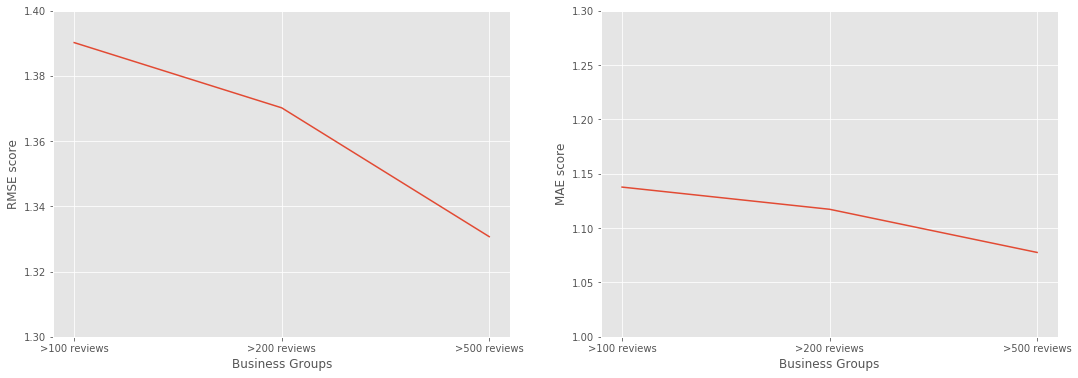

In [10]:
fig, ax=plt.subplots(1,2,figsize=(18,6))
ax[0].plot(['>100 reviews','>200 reviews','>500 reviews'],[1.3902,1.3702,1.3307])
ax[0].set_ylim(1.3,1.4)
ax[0].set_xlabel('Business Groups')
ax[0].set_ylabel('RMSE score')
ax[1].plot(['>100 reviews','>200 reviews','>500 reviews'],[1.1377,1.1173,1.0776])
ax[1].set_ylim(1.0,1.3)
ax[1].set_xlabel('Business Groups')
ax[1].set_ylabel('MAE score')